# Passive Portfolio Return Calculation

## Assumptions

1. **Dividend Reinvestment**: Dividends are reinvested on the ex-date at a configurable reinvestment ratio (0% = no reinvestment, 100% = full reinvestment). The reinvested amount uses the closing price on the ex-date.

2. **Tax Treatment**: Three separate configurable tax rates are applied to distributions *before* reinvestment:
   - **Dividend tax rate** — applied to regular cash dividends.
   - **Short-term capital gains tax rate** — applied to distributions classified as short-term capital gains.
   - **Long-term capital gains tax rate** — applied to distributions classified as long-term capital gains.
   - Mixed capital gains distributions are taxed at the average of the short-term and long-term rates.

3. **Capital Gains Distributions**: A toggle controls whether capital gains distributions from the fund are included at all. When excluded, only regular dividends contribute to the total return.

4. **Stock Splits**: Split adjustments are applied to the prior day's closing price so that the return on the ex-date is not distorted by the mechanical price change. For the 2025 timeframe, neither SPYV nor EMB has any splits.

5. **Price Field**: All calculations use `PRICECLOSE` (closing price) from the CRSP-style dataset. Securities are identified by `TRADINGITEMID`.

6. **Passive Portfolio (Buy-and-Hold)**: The portfolio starts at the specified initial weights (60% SPYV / 40% EMB). No rebalancing occurs; weights drift daily based on each asset's return.

7. **Fixed-Weight Portfolio (Bonus)**: The portfolio is rebalanced daily to maintain the target weights, implying daily rebalancing with no transaction costs.

8. **No Transaction Costs**: All calculations assume zero commissions, bid-ask spreads, or other trading frictions.

# Updates to make?

input: ticker, date, cost basis, quantity
can specify the lot id however, sell the highest one
rebalancing methods, quaterly, yearly (be able to specify the months), threshold based rebalancing

count the dividends and distrubutions and keep on track
add to calculate the tax rate based on year end profits

keep track on what trades was done

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# ── Configurable Parameters ──────────────────────────────────────────────────

# Portfolio tickers and starting weights (must sum to 1.0)
tickers = ['SPYV', 'EMB']
weights = [0.60, 0.40]

# Date range
start_date = '2025-01-01'
end_date   = '2025-12-31'

# Dividend reinvestment ratio: 0.0 = no reinvestment, 1.0 = full reinvestment
dividend_reinvestment_ratio = 1.0

# Whether to include capital gains distributions in return calculation
include_capital_gains_distributions = True

# Tax rates (applied to distributions before reinvestment)
dividend_tax_rate                  = 0.0   # e.g. 0.15 for 15% qualified dividend rate
short_term_capital_gains_tax_rate  = 0.0   # e.g. 0.37 for top ordinary income rate
long_term_capital_gains_tax_rate   = 0.0   # e.g. 0.20 for 20% long-term rate

# ─────────────────────────────────────────────────────────────────────────────
assert abs(sum(weights) - 1.0) < 1e-9, "Weights must sum to 1.0"
assert len(tickers) == len(weights), "Tickers and weights must have the same length"
print(f"Portfolio: {dict(zip(tickers, weights))}")
print(f"Period: {start_date} to {end_date}")
print(f"Dividend reinvestment ratio: {dividend_reinvestment_ratio:.0%}")
print(f"Include capital gains distributions: {include_capital_gains_distributions}")
print(f"Tax rates — Dividends: {dividend_tax_rate:.0%}, ST CG: {short_term_capital_gains_tax_rate:.0%}, LT CG: {long_term_capital_gains_tax_rate:.0%}")

Portfolio: {'SPYV': 0.6, 'EMB': 0.4}
Period: 2025-01-01 to 2025-12-31
Dividend reinvestment ratio: 100%
Include capital gains distributions: True
Tax rates — Dividends: 0%, ST CG: 0%, LT CG: 0%


In [5]:
# ── Load Data ────────────────────────────────────────────────────────────────

price_df    = pd.read_csv('../Dataset/price_data.csv', index_col=0)
dividend_df = pd.read_csv('../Dataset/dividend_data.csv', index_col=0)
splits_df   = pd.read_csv('../Dataset/splits_data.csv', index_col=0)

# Build a ticker -> TRADINGITEMID lookup from the price data
# Each ticker maps to the unique TRADINGITEMID(s) present in price_data
# Make sure all tickers are in uppercase
tickers = [t.upper() for t in tickers]
ticker_id_map = (
    price_df[price_df['TICKERSYMBOL'].isin(tickers)]
    .groupby('TICKERSYMBOL')['TRADINGITEMID']
    .first()
    .to_dict()
)

# Reverse map for labeling: TRADINGITEMID -> ticker
id_ticker_map = {v: k for k, v in ticker_id_map.items()}

print("Ticker → TRADINGITEMID mapping:")
for t, tid in ticker_id_map.items():
    print(f"  {t}: {tid}")

print(f"\nLoaded {len(price_df):,} price rows, {len(dividend_df):,} dividend rows, {len(splits_df):,} split rows")

Ticker → TRADINGITEMID mapping:
  EMB: 39599142
  SPYV: 37284811

Loaded 2,430,383 price rows, 55,064 dividend rows, 186 split rows


In [4]:
# ── Filter & Merge ───────────────────────────────────────────────────────────

selected_ids = list(ticker_id_map.values())

# Format dates
start_date = pd.Timestamp(start_date).strftime('%Y-%m-%d')
end_date   = pd.Timestamp(end_date).strftime('%Y-%m-%d')

# Filter prices: include one trading day before start_date for the baseline price
prices = (
    price_df[
        (price_df['TRADINGITEMID'].isin(selected_ids)) &
        (price_df['PRICEDATE'] <= end_date)
    ][['TRADINGITEMID', 'PRICEDATE', 'PRICECLOSE']]
    .copy()
)
prices['PRICEDATE'] = pd.to_datetime(prices['PRICEDATE'])
prices = prices.sort_values(['TRADINGITEMID', 'PRICEDATE']).reset_index(drop=True)

# Keep only dates >= last trading day before start_date
start_dt = pd.Timestamp(start_date)
baseline_dates = prices[prices['PRICEDATE'] < start_dt].groupby('TRADINGITEMID')['PRICEDATE'].max()
min_date = baseline_dates.min()
prices = prices[prices['PRICEDATE'] >= min_date].copy()

# ── Dividends ──────────────────────────────────────────────────────────────

# Classify distributions by tax type
SHORT_TERM_KEYWORDS = ['short term capital gains']
LONG_TERM_KEYWORDS  = ['long term capital gains']
MIXED_CG_KEYWORDS   = ['long and short term capital gains']

def classify_distribution(supplemental_name):
    """Return 'short_term_cg', 'long_term_cg', 'mixed_cg', or 'dividend'."""
    s = str(supplemental_name).lower()
    # Check mixed first (contains both "long" and "short")
    for kw in MIXED_CG_KEYWORDS:
        if kw in s:
            return 'mixed_cg'
    for kw in SHORT_TERM_KEYWORDS:
        if kw in s:
            return 'short_term_cg'
    for kw in LONG_TERM_KEYWORDS:
        if kw in s:
            return 'long_term_cg'
    return 'dividend'

divs = dividend_df[dividend_df['TRADINGITEMID'].isin(selected_ids)].copy()
divs['EXDATE'] = pd.to_datetime(divs['EXDATE'])
divs = divs[(divs['EXDATE'] >= start_dt) & (divs['EXDATE'] <= end_date)]
divs['dist_type'] = divs['SUPPLEMENTALTYPENAME'].apply(classify_distribution)

# Apply tax rates to get after-tax dividend amounts
def after_tax_amount(row):
    d = row['DIVAMOUNT']
    dtype = row['dist_type']
    if dtype == 'short_term_cg':
        return d * (1 - short_term_capital_gains_tax_rate)
    elif dtype == 'long_term_cg':
        return d * (1 - long_term_capital_gains_tax_rate)
    elif dtype == 'mixed_cg':
        avg_rate = (short_term_capital_gains_tax_rate + long_term_capital_gains_tax_rate) / 2
        return d * (1 - avg_rate)
    else:  # regular dividend
        return d * (1 - dividend_tax_rate)

divs['div_after_tax'] = divs.apply(after_tax_amount, axis=1)

# Optionally exclude capital gains distributions
if not include_capital_gains_distributions:
    divs = divs[divs['dist_type'] == 'dividend']

# Aggregate dividends per TRADINGITEMID + EXDATE (in case of multiple distributions on same day)
div_agg = (
    divs.groupby(['TRADINGITEMID', 'EXDATE'])['div_after_tax']
    .sum()
    .reset_index()
    .rename(columns={'EXDATE': 'PRICEDATE'})
)

# ── Splits ───────────────────────────────────────────────────────────────────

splits = splits_df[splits_df['TRADINGITEMID'].isin(selected_ids)].copy()
splits['EXDATE'] = pd.to_datetime(splits['EXDATE'])
splits = splits[(splits['EXDATE'] >= start_dt) & (splits['EXDATE'] <= end_date)]
split_agg = (
    splits.groupby(['TRADINGITEMID', 'EXDATE'])['RATE']
    .prod()  # in case of multiple splits on same day
    .reset_index()
    .rename(columns={'EXDATE': 'PRICEDATE', 'RATE': 'split_ratio'})
)

# ── Merge onto price series ──────────────────────────────────────────────────

prices = prices.merge(div_agg, on=['TRADINGITEMID', 'PRICEDATE'], how='left')
prices = prices.merge(split_agg, on=['TRADINGITEMID', 'PRICEDATE'], how='left')
prices['div_after_tax'] = prices['div_after_tax'].fillna(0.0)
prices['split_ratio']   = prices['split_ratio'].fillna(1.0)

# Add ticker label
prices['TICKER'] = prices['TRADINGITEMID'].map(id_ticker_map)

print(f"Price series: {len(prices)} rows across {prices['TICKER'].nunique()} tickers")
print(f"Date range: {prices['PRICEDATE'].min().date()} to {prices['PRICEDATE'].max().date()}")
print(f"\nDividend events in period: {(prices['div_after_tax'] > 0).sum()}")
print(f"Split events in period: {(prices['split_ratio'] != 1.0).sum()}")
prices.head()

Price series: 502 rows across 2 tickers
Date range: 2024-12-31 to 2025-12-31

Dividend events in period: 16
Split events in period: 0


,TRADINGITEMID,PRICEDATE,PRICECLOSE,div_after_tax,split_ratio,TICKER
0,37284811,2024-12-31,51.14,0.0,1.0,SPYV
1,37284811,2025-01-02,50.88,0.0,1.0,SPYV
2,37284811,2025-01-03,51.29,0.0,1.0,SPYV
3,37284811,2025-01-06,51.30,0.0,1.0,SPYV
4,37284811,2025-01-07,51.18,0.0,1.0,SPYV


In [12]:
# ── Daily Total Returns per Stock ─────────────────────────────────────────────
#
# r_t = (P_t + reinvestment_ratio * D_after_tax_t) / (P_{t-1} / split_ratio_t) - 1
#
# On a split ex-date, the prior close is divided by the split ratio so that the
# mechanical price drop is neutralized.  D_after_tax_t already has taxes applied.

# Sort to guarantee correct ordering within each security
prices = prices.sort_values(['TRADINGITEMID', 'PRICEDATE']).reset_index(drop=True)

# Previous close within each security
prices['prev_close'] = prices.groupby('TRADINGITEMID')['PRICECLOSE'].shift(1)

# Adjust previous close for splits on current date
# split_ratio > 1 means a forward split (e.g., 2:1 -> ratio=2)
prices['adjusted_prev_close'] = prices['prev_close'] / prices['split_ratio']

# Total return: price change + reinvested (after-tax) dividend
prices['daily_return'] = (
    (prices['PRICECLOSE'] + dividend_reinvestment_ratio * prices['div_after_tax'])
    / prices['adjusted_prev_close']
) - 1.0

# The first row per ticker is the baseline (no return), drop it
returns = prices.dropna(subset=['daily_return']).copy()

# Filter to only dates within [start_date, end_date]
returns = returns[
    (returns['PRICEDATE'] >= start_dt) &
    (returns['PRICEDATE'] <= end_date)
].copy()

# Display sample
print("Daily returns per stock (first few rows per ticker):")
for t in tickers:
    tid = ticker_id_map[t]
    sub = returns[returns['TRADINGITEMID'] == tid]
    print(f"\n{t} -- {len(sub)} trading days")
    print(sub[['PRICEDATE', 'PRICECLOSE', 'div_after_tax', 'split_ratio', 'daily_return']].head().to_string(index=False))

Daily returns per stock (first few rows per ticker):

SPYV -- 250 trading days
 PRICEDATE  PRICECLOSE  div_after_tax  split_ratio  daily_return
2025-01-02       50.88            0.0          1.0     -0.005084
2025-01-03       51.29            0.0          1.0      0.008058
2025-01-06       51.30            0.0          1.0      0.000195
2025-01-07       51.18            0.0          1.0     -0.002339
2025-01-08       51.23            0.0          1.0      0.000977

EMB -- 250 trading days
 PRICEDATE  PRICECLOSE  div_after_tax  split_ratio  daily_return
2025-01-02       89.34            0.0          1.0      0.003369
2025-01-03       89.50            0.0          1.0      0.001791
2025-01-06       89.54            0.0          1.0      0.000447
2025-01-07       89.18            0.0          1.0     -0.004021
2025-01-08       89.25            0.0          1.0      0.000785


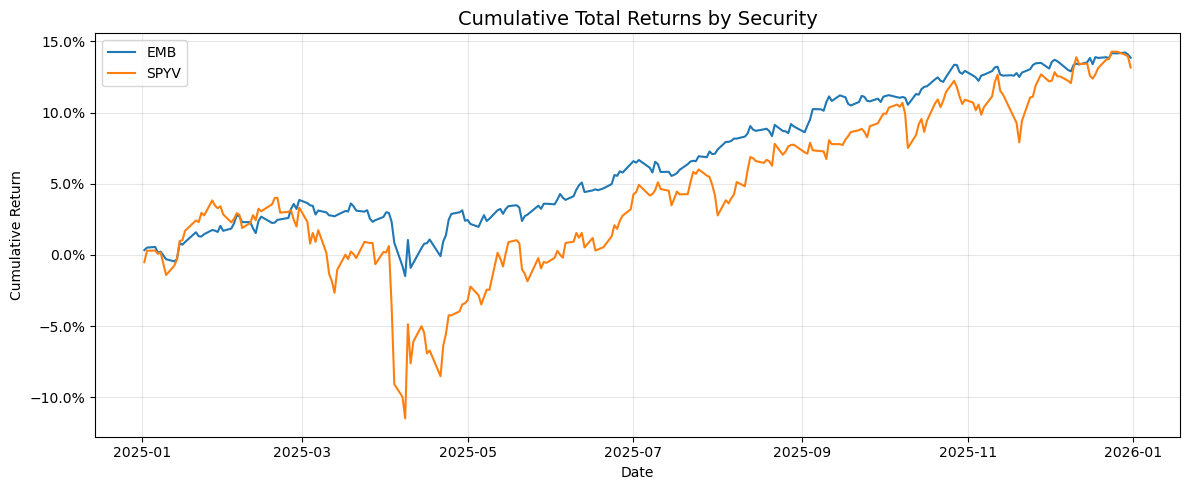


Cumulative return over the period:
  EMB: 13.8545%
  SPYV: 13.1660%

Annualized daily return statistics:
           mean      std       min      max
TICKER                                     
EMB    0.000528 0.004181 -0.019376 0.025768
SPYV   0.000543 0.009846 -0.057184 0.074706


In [13]:
# ── Cumulative Returns per Stock ──────────────────────────────────────────────
#
# CumReturn_t = product(1 + r_i for i = 1..t) - 1

# Pivot daily returns to wide format: rows = dates, columns = tickers
daily_ret_wide = returns.pivot_table(
    index='PRICEDATE', columns='TICKER', values='daily_return'
).sort_index()

# Cumulative returns (growth of $1)
cum_ret_wide = (1 + daily_ret_wide).cumprod() - 1

# ── Plot cumulative returns ──────────────────────────────────────────────────

fig, ax = plt.subplots(figsize=(12, 5))
for col in cum_ret_wide.columns:
    ax.plot(cum_ret_wide.index, cum_ret_wide[col], label=col, linewidth=1.5)

ax.set_title('Cumulative Total Returns by Security', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.legend()
ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

# Summary stats
print("\nCumulative return over the period:")
for col in cum_ret_wide.columns:
    print(f"  {col}: {cum_ret_wide[col].iloc[-1]:.4%}")

print("\nAnnualized daily return statistics:")
print(daily_ret_wide.describe().T[['mean', 'std', 'min', 'max']].to_string(float_format='{:.6f}'.format))

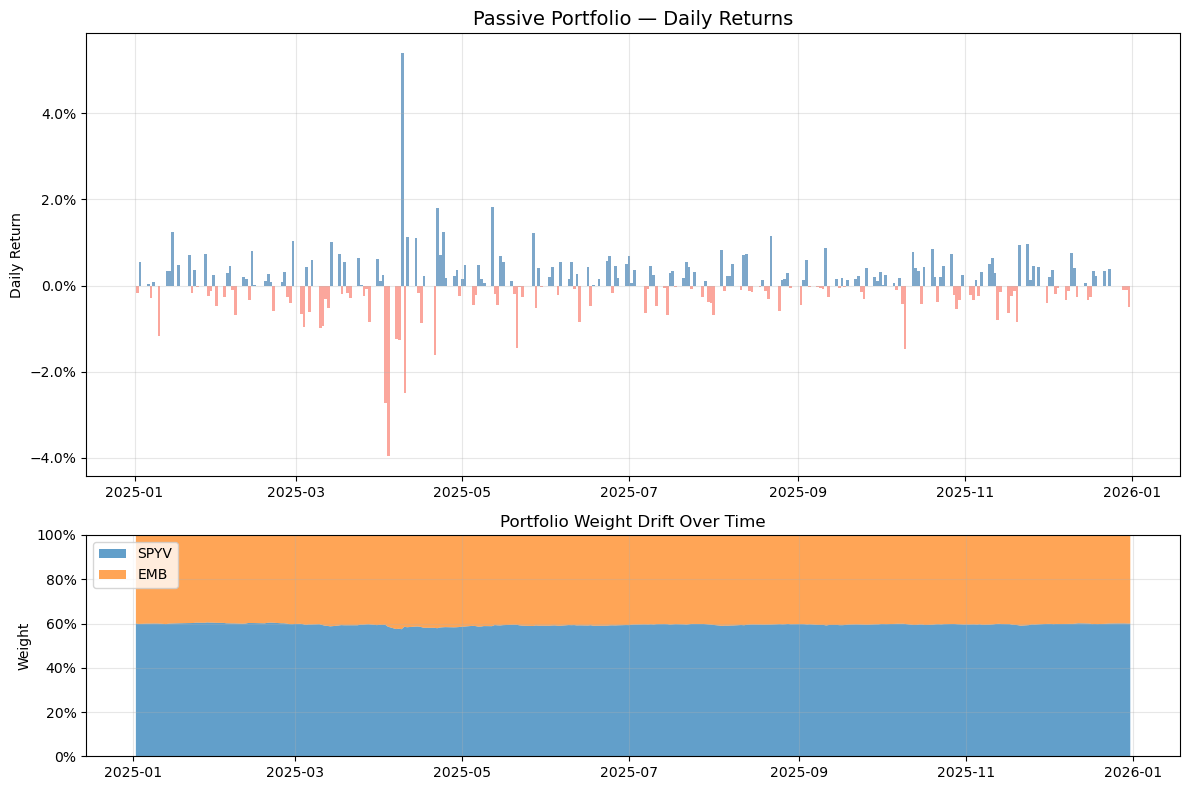

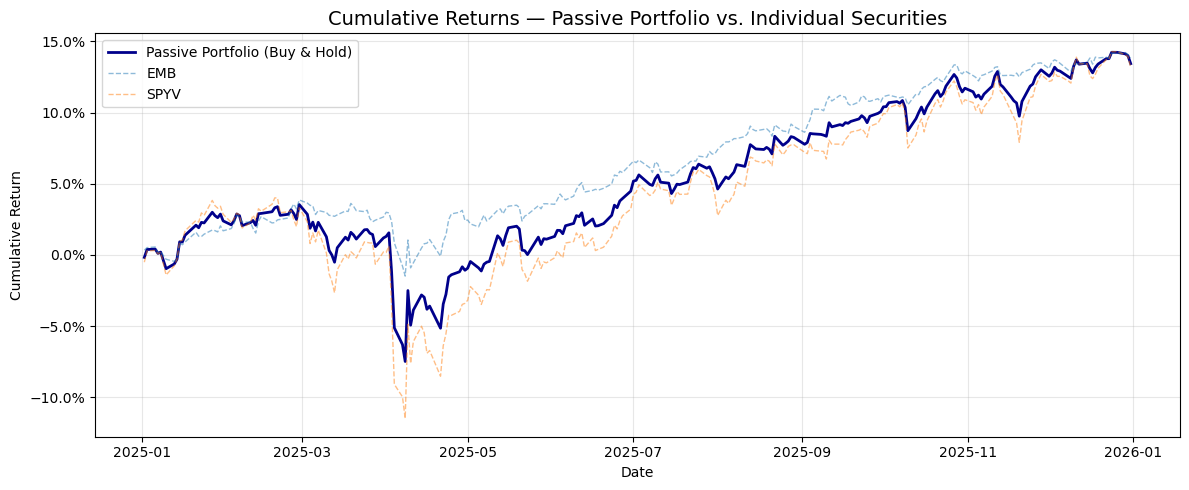


Passive Portfolio Results (2025-01-01 to 2025-12-31):
  Cumulative return:   13.4414%
  Annualized volatility: 11.2373%
  Final weights: SPYV: 0.5985, EMB: 0.4015


In [14]:
# ── Passive Portfolio — Daily & Cumulative Returns (Drifting Weights) ─────────
#
# Buy-and-hold: start at initial weights, let them drift with returns.
#   r_p_t  = sum(w_{t-1,i} * r_{i,t})
#   w_t_i  = w_{t-1,i} * (1 + r_{i,t}) / sum(w_{t-1,j} * (1 + r_{j,t}))

# Ensure tickers are in the same order as the weights vector
ordered_tickers = tickers  # same order as `weights`
ret_matrix = daily_ret_wide[ordered_tickers].values  # (T, N)
T, N = ret_matrix.shape

portfolio_daily_returns = np.empty(T)
weight_history = np.empty((T + 1, N))
weight_history[0] = weights  # initial weights

for t in range(T):
    r_t = ret_matrix[t]  # returns on day t for each asset
    w_prev = weight_history[t]
    
    # Portfolio return for the day
    portfolio_daily_returns[t] = np.dot(w_prev, r_t)
    
    # Update weights (drift)
    w_new = w_prev * (1 + r_t)
    weight_history[t + 1] = w_new / w_new.sum()

# Build a DataFrame
dates = daily_ret_wide.index
passive_df = pd.DataFrame({
    'date': dates,
    'portfolio_daily_return': portfolio_daily_returns,
})
passive_df['portfolio_cum_return'] = (1 + passive_df['portfolio_daily_return']).cumprod() - 1

# Weight history DataFrame (beginning-of-day weights)
weight_df = pd.DataFrame(weight_history[:-1], columns=ordered_tickers, index=dates)

# ── Plot: Passive Portfolio Daily Returns ────────────────────────────────────

fig, axes = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [2, 1]})

# Daily returns
ax1 = axes[0]
ax1.bar(passive_df['date'], passive_df['portfolio_daily_return'],
        color=np.where(passive_df['portfolio_daily_return'] >= 0, 'steelblue', 'salmon'),
        width=1, alpha=0.7)
ax1.set_title('Passive Portfolio — Daily Returns', fontsize=14)
ax1.set_ylabel('Daily Return')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax1.grid(True, alpha=0.3)

# Weight drift
ax2 = axes[1]
ax2.stackplot(weight_df.index, *[weight_df[c] for c in ordered_tickers],
              labels=ordered_tickers, alpha=0.7)
ax2.set_title('Portfolio Weight Drift Over Time', fontsize=12)
ax2.set_ylabel('Weight')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax2.legend(loc='upper left')
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

# ── Plot: Passive Portfolio Cumulative Return ────────────────────────────────

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(passive_df['date'], passive_df['portfolio_cum_return'],
        color='darkblue', linewidth=2, label='Passive Portfolio (Buy & Hold)')
# Overlay individual securities for comparison
for col in cum_ret_wide.columns:
    ax.plot(cum_ret_wide.index, cum_ret_wide[col], linewidth=1, alpha=0.5, linestyle='--', label=col)
ax.set_title('Cumulative Returns — Passive Portfolio vs. Individual Securities', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.legend()
ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

# Summary
final_cum = passive_df['portfolio_cum_return'].iloc[-1]
ann_vol = passive_df['portfolio_daily_return'].std() * np.sqrt(252)
print(f"\nPassive Portfolio Results ({start_date} to {end_date}):")
print(f"  Cumulative return:   {final_cum:.4%}")
print(f"  Annualized volatility: {ann_vol:.4%}")

# Final drifted weights (do NOT overwrite the global `weights` variable)
final_drifted = weight_history[-1].round(4).tolist()
formatted_pairs = [f"{t}: {w}" for t, w in zip(ordered_tickers, final_drifted)]
print(f"  Final weights: {', '.join(formatted_pairs)}")

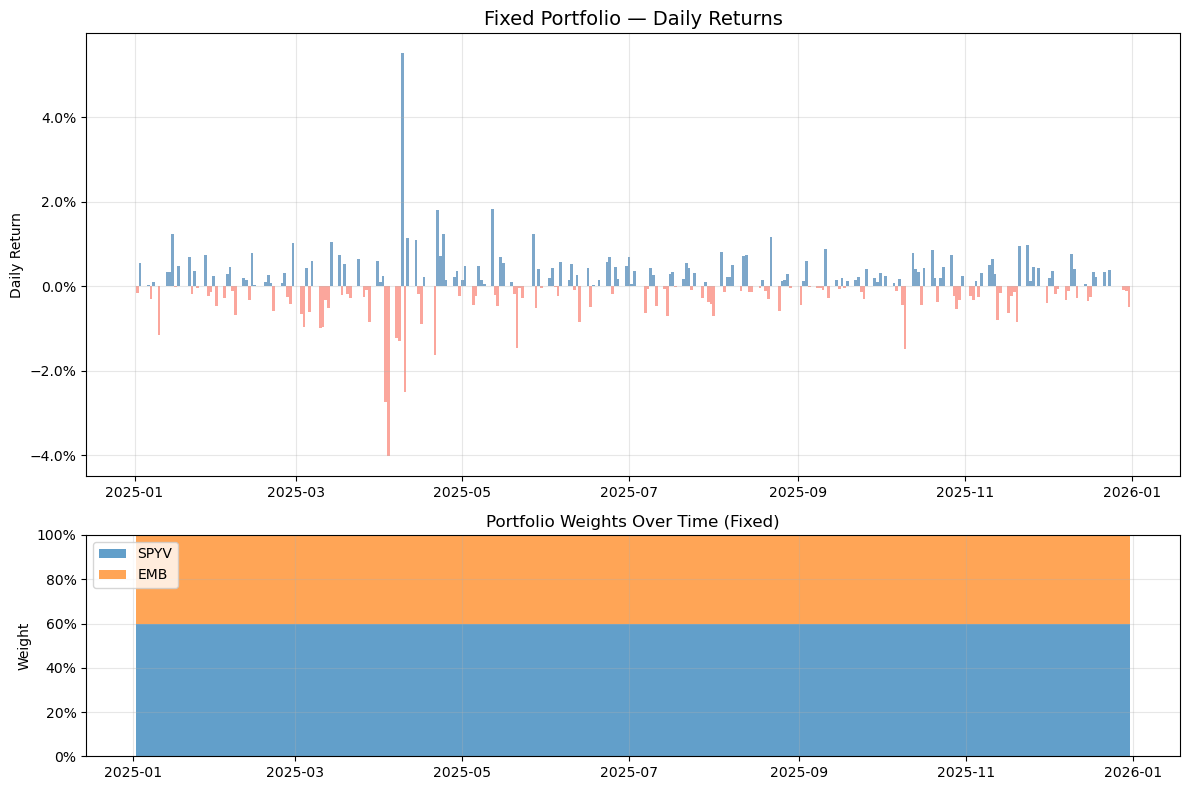

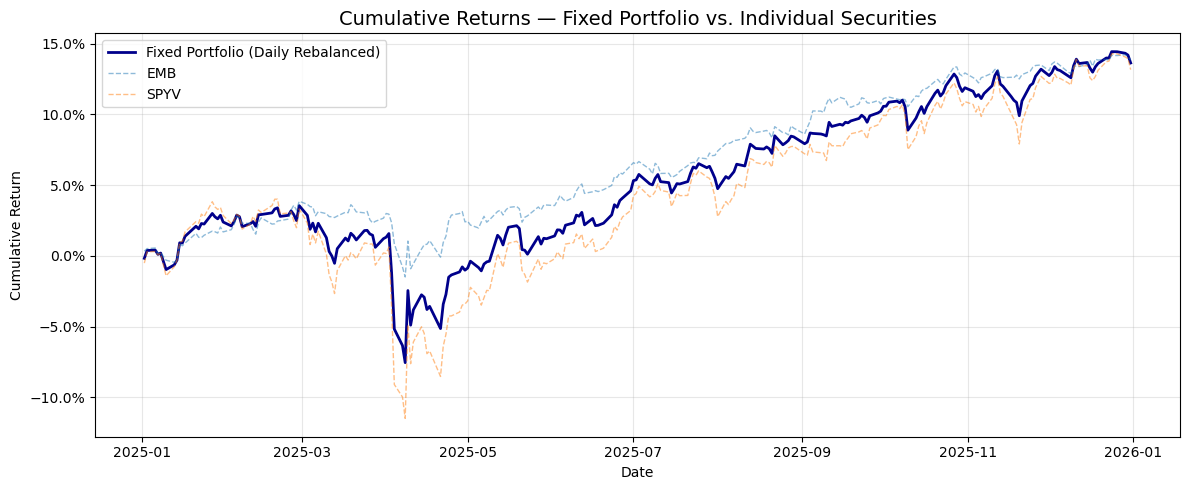


Fixed Portfolio Results (2025-01-01 to 2025-12-31):
   Cumulative return:     13.6368%
   Annualized volatility: 11.3674%
   Target weights (constant): SPYV: 0.6, EMB: 0.4


In [15]:
# ── (Bonus) Fixed-Weight Portfolio — Daily Rebalancing ────────────────────────
#
# r_p_t = sum(w_i * r_{i,t})   where w_i are the CONSTANT target weights.
# This implies the portfolio is rebalanced to target weights at the close of
# each trading day (no transaction costs assumed).

fixed_weight_daily = daily_ret_wide[ordered_tickers].values @ np.array(weights)

fixed_df = pd.DataFrame({
    'date': dates,
    'fixed_daily_return': fixed_weight_daily,
})
fixed_df['fixed_cum_return'] = (1 + fixed_df['fixed_daily_return']).cumprod() - 1

# Weight DataFrame -- constant target weights (fixed portfolio never drifts)
fixed_weight_df = pd.DataFrame(
    np.tile(weights, (len(dates), 1)),
    columns=ordered_tickers,
    index=dates
)

# ── Plot: Fixed Portfolio Daily Returns & Weights ─────────────────────────────

fig, axes = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [2, 1]})

# Daily returns
ax1 = axes[0]
ax1.bar(fixed_df['date'], fixed_df['fixed_daily_return'],
        color=np.where(fixed_df['fixed_daily_return'] >= 0, 'steelblue', 'salmon'),
        width=1, alpha=0.7)
ax1.set_title('Fixed Portfolio — Daily Returns', fontsize=14)
ax1.set_ylabel('Daily Return')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax1.grid(True, alpha=0.3)

# Weights (constant -- fixed portfolio is rebalanced daily to target)
ax2 = axes[1]
ax2.stackplot(fixed_weight_df.index, *[fixed_weight_df[c] for c in ordered_tickers],
              labels=ordered_tickers, alpha=0.7)
ax2.set_title('Portfolio Weights Over Time (Fixed)', fontsize=12)
ax2.set_ylabel('Weight')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax2.legend(loc='upper left')
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

# ── Plot: Fixed Portfolio Cumulative Return ──────────────────────────────────

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(fixed_df['date'], fixed_df['fixed_cum_return'],
        color='darkblue', linewidth=2, label='Fixed Portfolio (Daily Rebalanced)')

# Overlay individual securities for comparison
for col in cum_ret_wide.columns:
    ax.plot(cum_ret_wide.index, cum_ret_wide[col], linewidth=1, alpha=0.5, linestyle='--', label=col)

ax.set_title('Cumulative Returns — Fixed Portfolio vs. Individual Securities', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.legend()
ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

# Summary
final_cum = fixed_df['fixed_cum_return'].iloc[-1]
ann_vol = fixed_df['fixed_daily_return'].std() * np.sqrt(252)

print(f"\nFixed Portfolio Results ({start_date} to {end_date}):")
print(f"   Cumulative return:     {final_cum:.4%}")
print(f"   Annualized volatility: {ann_vol:.4%}")

# Fixed-weight portfolio always holds the target weights
formatted_pairs = [f"{t}: {w}" for t, w in zip(ordered_tickers, weights)]
print(f"   Target weights (constant): {', '.join(formatted_pairs)}")

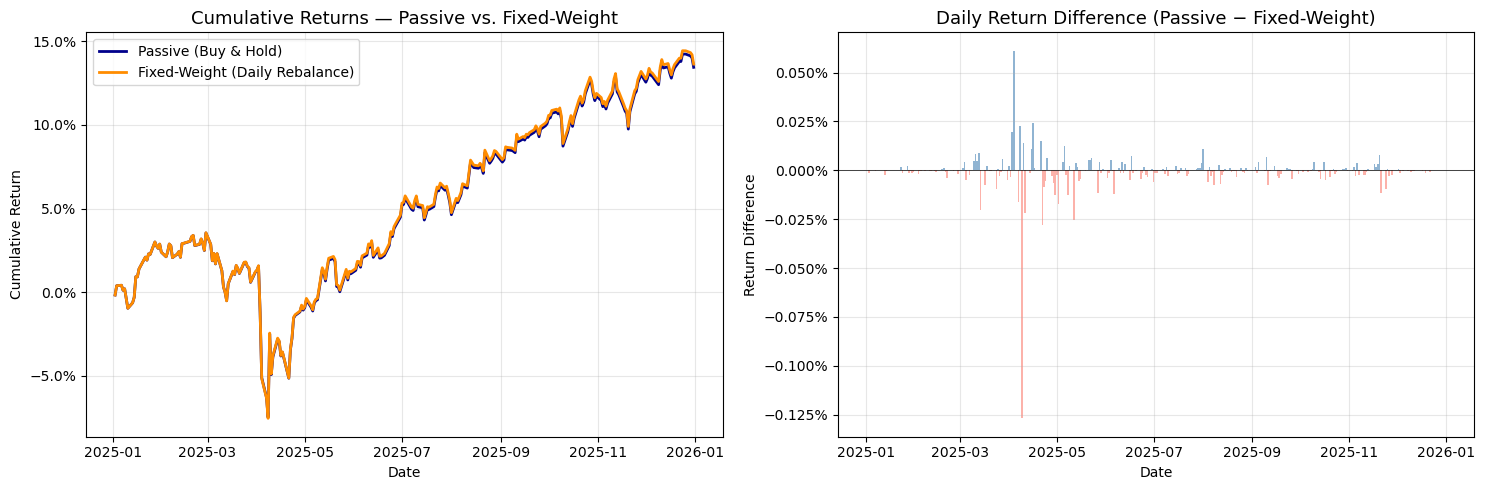

                      Strategy Cumulative Return Annualized Volatility Sharpe (approx, rf=0)
          Passive (Buy & Hold)          13.4414%              11.2373%                1.1961
Fixed-Weight (Daily Rebalance)          13.6368%              11.3674%                1.1996


In [16]:
# ── Comparison: Passive vs Fixed-Weight ──────────────────────────────────────

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Cumulative returns comparison
ax1 = axes[0]
ax1.plot(passive_df['date'], passive_df['portfolio_cum_return'],
         color='darkblue', linewidth=2, label='Passive (Buy & Hold)')
ax1.plot(fixed_df['date'], fixed_df['fixed_cum_return'],
         color='darkorange', linewidth=2, label='Fixed-Weight (Daily Rebalance)')
ax1.set_title('Cumulative Returns — Passive vs. Fixed-Weight', fontsize=13)
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Return')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax1.legend()
ax1.grid(True, alpha=0.3)

# Daily return difference
diff = passive_df['portfolio_daily_return'].values - fixed_df['fixed_daily_return'].values
ax2 = axes[1]
ax2.bar(dates, diff, width=1, alpha=0.6,
        color=np.where(diff >= 0, 'steelblue', 'salmon'))
ax2.set_title('Daily Return Difference (Passive − Fixed-Weight)', fontsize=13)
ax2.set_xlabel('Date')
ax2.set_ylabel('Return Difference')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax2.axhline(0, color='black', linewidth=0.5)
ax2.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

# ── Summary Table ────────────────────────────────────────────────────────────

passive_final = passive_df['portfolio_cum_return'].iloc[-1]
fixed_final   = fixed_df['fixed_cum_return'].iloc[-1]
passive_vol   = passive_df['portfolio_daily_return'].std() * np.sqrt(252)
fixed_vol     = fixed_df['fixed_daily_return'].std() * np.sqrt(252)

summary = pd.DataFrame({
    'Strategy': ['Passive (Buy & Hold)', 'Fixed-Weight (Daily Rebalance)'],
    'Cumulative Return': [f"{passive_final:.4%}", f"{fixed_final:.4%}"],
    'Annualized Volatility': [f"{passive_vol:.4%}", f"{fixed_vol:.4%}"],
    'Sharpe (approx, rf=0)': [
        f"{(passive_final / passive_vol):.4f}" if passive_vol > 0 else "N/A",
        f"{(fixed_final / fixed_vol):.4f}" if fixed_vol > 0 else "N/A",
    ],
})
print(summary.to_string(index=False))